In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import random
import os
import glob
import numpy as np
import pandas as pan
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Input, Activation
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam, Nadam, RMSprop, schedules
from keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.regularizers import l2


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<em>This is Image Classification Task that I do not fully understand but I'm going to do because I'm now putting all my self worth on kaggle <em/>

In [ ]:
DATA_DIR = "working/augmentedData"

#walk all the files and add them to this
all_files = [i for i in glob.glob(DATA_DIR + "//*//*")]
#shuffle
random.shuffle(all_files)
#get class names
all_labels = [os.path.dirname(i).split("/")[-1] for i in all_files]

In [ ]:
#make data frame, then do some EDA? #someone can fork this an do some good stuff with it though
zipped_data = list(zip(all_files, all_labels))
data_frame = pan.DataFrame(zipped_data, columns = ["Links", "Label"])

In [ ]:
#severe class imbalance; undersample majority class (which is literally a white patch)
data_frame["Label"].value_counts()
#lets sample 400 images of everything and concat to a new df
balance_df = pan.DataFrame()
large_labels = ["good", "thread error", "objects", "oil spot"]
for i in large_labels:
    balance_df = pan.concat([data_frame[data_frame["Label"] == i], balance_df], axis = 0)
balance_df = pan.concat([data_frame[data_frame["Label"] == "hole"], balance_df])#concat seperately as it has only 300 elems
balance_df["Label"].value_counts()

Label
oil spot        5088
hole            5055
objects         5022
good            5000
thread error    4960
Name: count, dtype: int64

hole


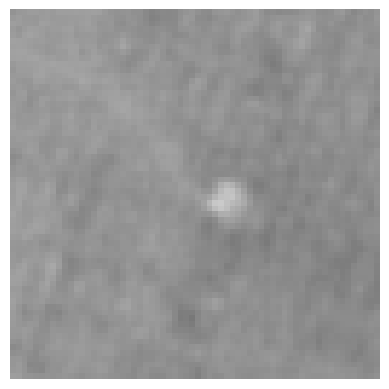

In [ ]:
#first see one of the images
test_arr = mpimg.imread(balance_df.iloc[675]["Links"])

# Print the label for the image at index 675
print(balance_df.iloc[675]["Label"])

# Display the image
plt.imshow(test_arr)
plt.axis('off')  # Hide the axis for better visualization
plt.show()

<Axes: xlabel='Label', ylabel='count'>

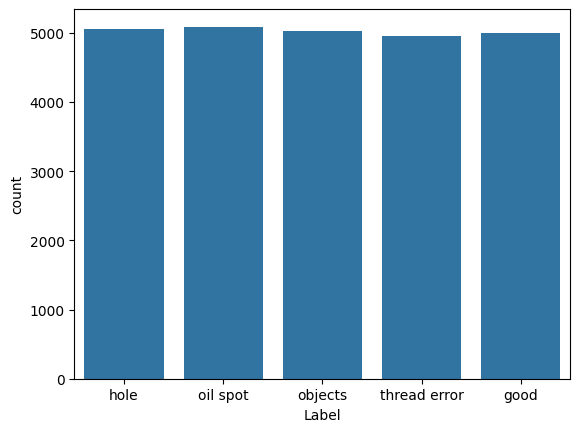

In [ ]:
sns.countplot(x = balance_df["Label"]) #MASSIVE CLASS IMBALANCE GONE LOL

In [ ]:
#perform train_test_split
#label encode
labeller = dict(zip([i for i in balance_df["Label"].unique()], [i for i in range(len(balance_df["Label"].unique()))]))
features = balance_df["Links"]
label = balance_df["Label"].map(labeller)

feature_train, feature_eval, label_train, label_eval = train_test_split(features, label, test_size = 0.2, random_state = 101)
labeller

{'hole': 0, 'oil spot': 1, 'objects': 2, 'thread error': 3, 'good': 4}

In [ ]:
# vals = label.value_counts().apply(lambda x: (x/len(label)) ** -1)
# keys = label.value_counts().index

# weights = dict(zip(keys, vals))

In [ ]:
#define dataset objects and preprocessors
feature_train_dataset = tf.data.Dataset.from_tensor_slices(feature_train.values)
feature_test_dataset = tf.data.Dataset.from_tensor_slices(feature_eval.values)
label_train_dataset = tf.data.Dataset.from_tensor_slices(label_train)
label_test_dataset = tf.data.Dataset.from_tensor_slices(label_eval)


def preprocessor(image):
    image = tf.io.read_file(image)
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.image.resize(image, (64, 64))
    image = image/255
    return image

feature_train_dataset = feature_train_dataset.map(preprocessor)
feature_test_dataset = feature_test_dataset.map(preprocessor)

train = tf.data.Dataset.zip((feature_train_dataset, label_train_dataset))
test = tf.data.Dataset.zip((feature_test_dataset, label_test_dataset))

train = train.batch(32).shuffle(32).prefetch(tf.data.AUTOTUNE)
test = test.batch(256).prefetch(tf.data.AUTOTUNE)

In [ ]:
feature_train_dataset

<_MapDataset element_spec=TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None)>

In [ ]:
def silu(x):
    return x * tf.keras.activations.sigmoid(x)

def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Example block of SiLU and Conv layers
    x = Conv2D(32, (3, 3), padding='same')(inputs)
    x = Activation(silu)(x)

    for _ in range(20):  # Adjust according to your model depth
        x = Conv2D(32, (3, 3), padding='same')(x)
        x = Activation(silu)(x)

    x = Conv2D(64, (3, 3), padding='same', strides=2)(x)
    x = Activation(silu)(x)

    for _ in range(20):  # Adjust according to your model depth
        x = Conv2D(64, (3, 3), padding='same')(x)
        x = Activation(silu)(x)

    x = Conv2D(128, (3, 3), padding='same', strides=2)(x)
    x = Activation(silu)(x)

    for _ in range(20):  # Adjust according to your model depth
        x = Conv2D(128, (3, 3), padding='same')(x)
        x = Activation(silu)(x)

    x = Conv2D(256, (3, 3), padding='same', strides=2)(x)
    x = Activation(silu)(x)

    for _ in range(20):  # Adjust according to your model depth
        x = Conv2D(256, (3, 3), padding='same')(x)
        x = Activation(silu)(x)

    x = Conv2D(512, (3, 3), padding='same', strides=2)(x)
    x = Activation(silu)(x)

    for _ in range(20):  # Adjust according to your model depth
        x = Conv2D(512, (3, 3), padding='same')(x)
        x = Activation(silu)(x)

    x = Conv2D(1280, (1, 1), padding='same')(x)
    x = Activation(silu)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Define input shape and number of classes
input_shape = (64, 64, 3)  # Adjust according to your input shape
num_classes = 5  # Adjust according to your number of classes

# Build and compile the model
model = build_model(input_shape, num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Build and compile the model
model = build_model(input_shape, num_classes)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_106 (Conv2D)         (None, 64, 64, 32)        896       
                                                                 
 activation_106 (Activation  (None, 64, 64, 32)        0         
 )                                                               
                                                                 
 conv2d_107 (Conv2D)         (None, 64, 64, 32)        9248      
                                                                 
 activation_107 (Activation  (None, 64, 64, 32)        0         
 )                                                               
                                                                 
 conv2d_108 (Conv2D)         (None, 64, 64, 32)        9248

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=0.00001)
history = model.fit(train, validation_data = [test], callbacks=[early_stopping, reduce_lr], epochs = 100)

Epoch 1/100
629/629 [==============================] - 52s 16ms/step - loss: 2.8294 - accuracy: 0.2107 - val_loss: 2.0883 - val_accuracy: 0.2070 - lr: 0.0010
Epoch 2/100
629/629 [==============================] - 10s 16ms/step - loss: 1.9739 - accuracy: 0.2248 - val_loss: 1.9242 - val_accuracy: 0.2287 - lr: 0.0010
Epoch 3/100
629/629 [==============================] - 10s 15ms/step - loss: 1.8780 - accuracy: 0.2553 - val_loss: 1.9033 - val_accuracy: 0.2404 - lr: 0.0010
Epoch 4/100
629/629 [==============================] - 10s 15ms/step - loss: 1.7968 - accuracy: 0.3322 - val_loss: 1.8341 - val_accuracy: 0.3375 - lr: 0.0010
Epoch 5/100
629/629 [==============================] - 10s 15ms/step - loss: 1.7531 - accuracy: 0.3973 - val_loss: 1.8968 - val_accuracy: 0.3705 - lr: 0.0010
Epoch 6/100
629/629 [==============================] - 10s 15ms/step - loss: 1.7173 - accuracy: 0.4351 - val_loss: 2.0147 - val_accuracy: 0.3230 - lr: 0.0010
Epoch 7/100
629/629 [==============================]

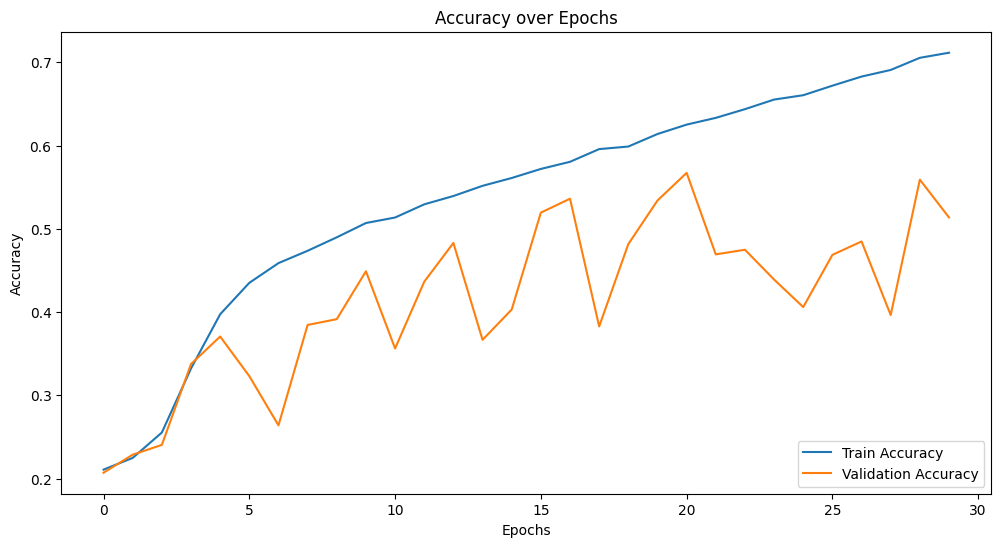

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy over Epochs')
plt.show()